In [1]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
CONTENT_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/reference/"

NOISY500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy500"
NOISY2500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy2500"
NOISY20 = "/home/yifan/dataset/noisy/pairflip/cifar10/20"
NOISY0 = "/home/yifan/dataset/noisy/pairflip/cifar10/0"
sys.path.append(REF_PATH)
sys.path.append(CONTENT_PATH)

from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


from config import config

ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
# REFERENCE
noisy_data_provider = NormalDataProvider(NOISY0,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )

clean_data_provider = NormalDataProvider(CLEAN_PATH,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1  )
clean_data = clean_data_provider.train_representation(200).squeeze()

ref_train_data = ref_provider.train_representation(200).squeeze()

# EPOCH 200
train_data = data_provider.train_representation(200).squeeze()
# EPOCH 199
# prev_train_data = data_provider.train_representation(199).squeeze()

noisy_data = noisy_data_provider.train_representation(200).squeeze()

Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [3]:
from torch import nn


import scipy
import numpy as np
from sklearn.cross_decomposition import CCA

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

# Step1: Computing the loss 
def compute_loss(X,Y,R):
    '''
     The loss function will be the squared Frobenoius norm of the difference between the matrix and its approximation, divided by the number of training examples m
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
        L: a matrix of dimension (m,n) -the value of the loss function for given X, Y and R
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    m = len(X)
    Xnew = np.dot(X, R)
    # Ynew = np.dot(Y, R)
    # diff is Projector(XR) - Projector(Y) 
    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, Xnew)
    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)
    

    # Xnew = np.dot(X, R)

    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    diff = projector.batch_project(200, np.dot(X, R)) - projector.batch_project(200, Y)

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss


# Step2: Computing the loss 
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)
    Xnew = np.dot(X, R)


    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, Xnew)
    rows, columns = X.shape

    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)

    diff = projector.batch_project(200, np.dot(X, R)) - projector.batch_project(200, Y)

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    loss = sum_diff_squared/m
    # gradient is X^T(XR - Y) * 2/m
    # gradient = (np.dot(inv_X.T, np.dot(inv_X, R) - inv_Y))/rows
    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    # gradient = torch.autograd.grad(outputs = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows, inputs=torch.tensor(R), only_inputs=True, create_graph=True )
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient,loss



# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps: int=1500,
                      learning_rate: float=0.0005,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient,loss = compute_gradient(X, Y, R)
       
        print(f"loss at iteration {i} is: {loss:.4f}")
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R

np.random.seed(129)
m = 10
n = 5
X = noisy_data
Y = clean_data
R = align_embeddings(X, Y)


print(R)


Euclid 803.6293585358034
loss at iteration 0 is: 668590.6534
Euclid 507.11624817510443
loss at iteration 1 is: 265870.0083
Euclid 320.5965432207509
loss at iteration 2 is: 106071.2448
Euclid 203.41244179534928
loss at iteration 3 is: 42615.3958
Euclid 129.90662049705966
loss at iteration 4 is: 17360.0320
Euclid 83.87432958345646
loss at iteration 5 is: 7252.0506
Euclid 55.103297636556775
loss at iteration 6 is: 3162.8099
Euclid 37.00048369971124
loss at iteration 7 is: 1470.0413
Euclid 25.30620086017317
loss at iteration 8 is: 741.5335
Euclid 18.890060511418707
loss at iteration 9 is: 437.0530
Euclid 15.784800816179898
loss at iteration 10 is: 303.4576
Euclid 13.831548963733118
loss at iteration 11 is: 232.8166
Euclid 12.606126855713706
loss at iteration 12 is: 193.9072
Euclid 11.838978693170901
loss at iteration 13 is: 171.4750
Euclid 11.32330929225081
loss at iteration 14 is: 157.4132
Euclid 10.959571975717695
loss at iteration 15 is: 147.8880
Euclid 10.689664906997777
loss at iterat

In [116]:
noisy2500_data_provider = NormalDataProvider(NOISY2500,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )
noisy2500_data = noisy2500_data_provider.train_representation(200).squeeze()
R2500 = align_embeddings(noisy2500_data, clean_data)

Finish initialization...
Euclid 381.4905810861234
loss at iteration 0 is: 151146.1171
Euclid 244.12834525481497
loss at iteration 1 is: 61839.3856
Euclid 156.466657823529
loss at iteration 2 is: 25376.2970
Euclid 100.50226946057941
loss at iteration 3 is: 10468.2125
Euclid 64.6834753167908
loss at iteration 4 is: 4351.4474
Euclid 41.81981856809845
loss at iteration 5 is: 1844.1800
Euclid 27.288169586657254
loss at iteration 6 is: 816.7765
Euclid 18.695876512174404
loss at iteration 7 is: 407.2148
Euclid 14.309163126700847
loss at iteration 8 is: 246.9294
Euclid 12.069551418497092
loss at iteration 9 is: 177.7756
Euclid 10.8085762583716
loss at iteration 10 is: 143.9397
Euclid 10.078393063937254
loss at iteration 11 is: 126.3148
Euclid 9.599074851724763
loss at iteration 12 is: 115.3264
Euclid 9.307680827718405
loss at iteration 13 is: 108.7763
Euclid 9.124090406406344
loss at iteration 14 is: 104.7358
Euclid 8.990535489663339
loss at iteration 15 is: 101.8245
Euclid 8.895679110298577
l

In [117]:
###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = np.dot(noisy2500_data,R)
Y = noisy2500_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('noisy20  epoch 1 vs epoch200 ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

noisy20  epoch 1 vs epoch200 
0.9999999999999987


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9332.12it/s]


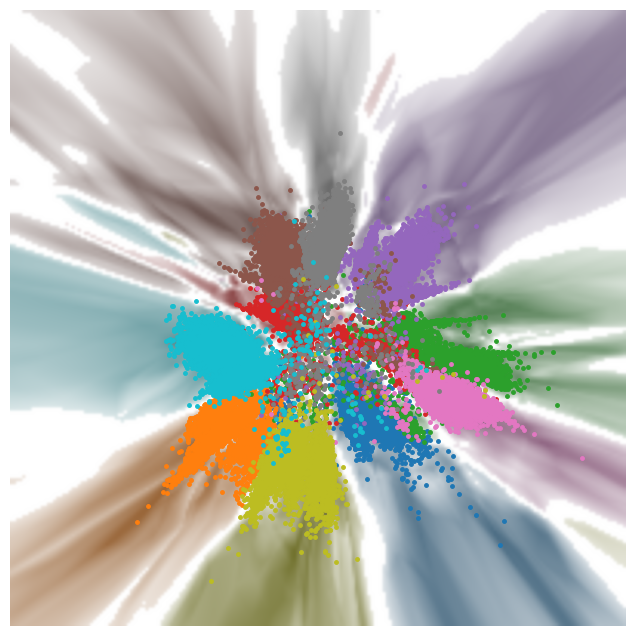

In [115]:

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY0, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer

vis = visualizer(noisy_data_provider, noisy_data, projector, 200, 'tab10')
# vis = visualizer(data_provider, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9277.79it/s]


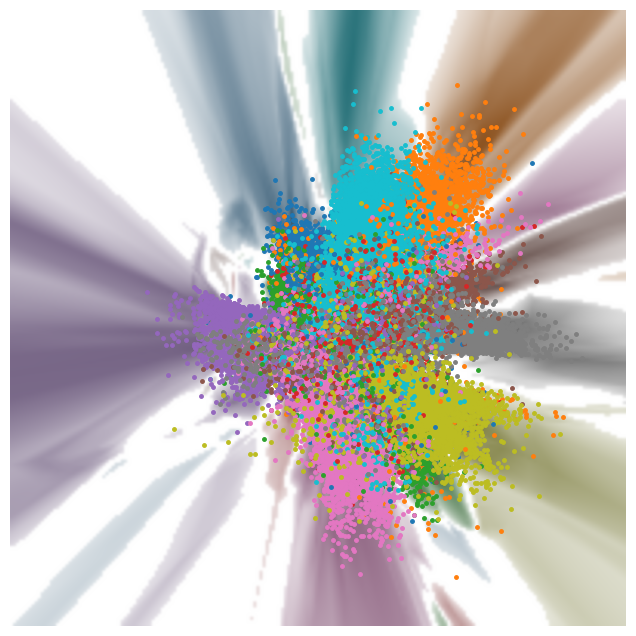

In [123]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data,R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Successfully load the TimeVis visualization model for iteration 200
Computing decision regions ...
Successfully load the TimeVis visualization model for iteration 200
Successfully load the TimeVis visualization model for iteration 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 9720.74it/s]


Successfully load the TimeVis visualization model for iteration 200


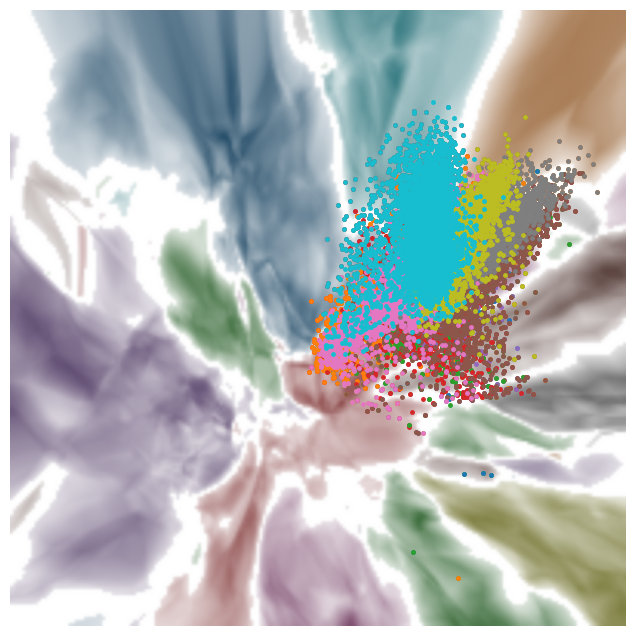

In [142]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, noisy_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [125]:
import json
import os
import numpy as np
clean_path = os.path.join(NOISY2500, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(NOISY2500, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
noisy_indicates = []
clean_indicates = []
pairs = []
for i in range(len(clean_labels)):
    if clean_labels[i] != noisy_labels[i]:
        noisy_indicates.append(i)
        pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})
    else:
        clean_indicates.append(i)
print(len(noisy_indicates))

2500


In [126]:
CLEAN = np.dot(noisy_data, R)
NOISY = np.dot(noisy2500_data, R2500)

CLEAN_2d = projector.batch_project(200, CLEAN)
NOISY_2d = projector.batch_project(200, NOISY)
EuclidClean = 0
EuclidNoisy = 0
noisy_num = len(noisy_indicates)
clean_num = len(clean_indicates)
for m in range(len(noisy_indicates)):
        i = noisy_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidNoisy = EuclidNoisy + d


for m in range(len(clean_indicates)):
        i = clean_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidClean = EuclidClean + d
# print('Euclid',Euclid/m)
print('clean distance:',EuclidClean/clean_num,'noisy distance:',EuclidNoisy/noisy_num,)
    

clean distance: 4.589530677616071 noisy distance: 5.6545305406478


Successfully load the TimeVis visualization model for iteration 200
Computing decision regions ...
Successfully load the TimeVis visualization model for iteration 200
Successfully load the TimeVis visualization model for iteration 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2302.99it/s]


Successfully load the TimeVis visualization model for iteration 200


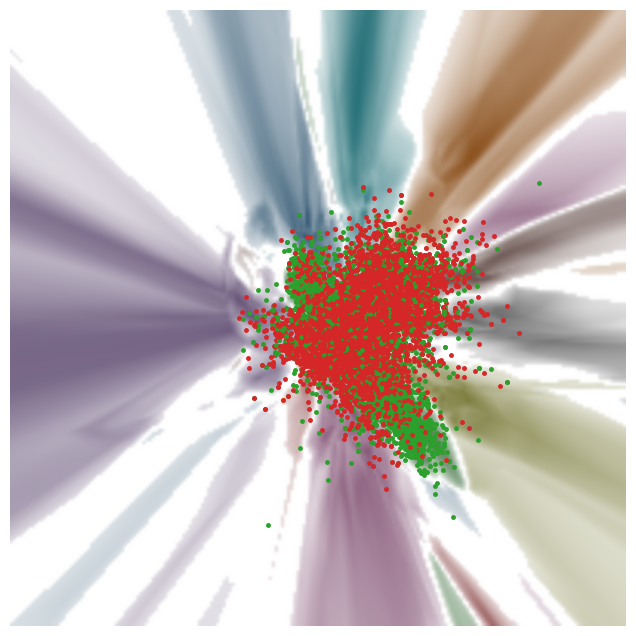

In [97]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data, R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Successfully load the TimeVis visualization model for iteration 200
Computing decision regions ...
Successfully load the TimeVis visualization model for iteration 200
Successfully load the TimeVis visualization model for iteration 200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 468.27it/s]


Successfully load the TimeVis visualization model for iteration 200


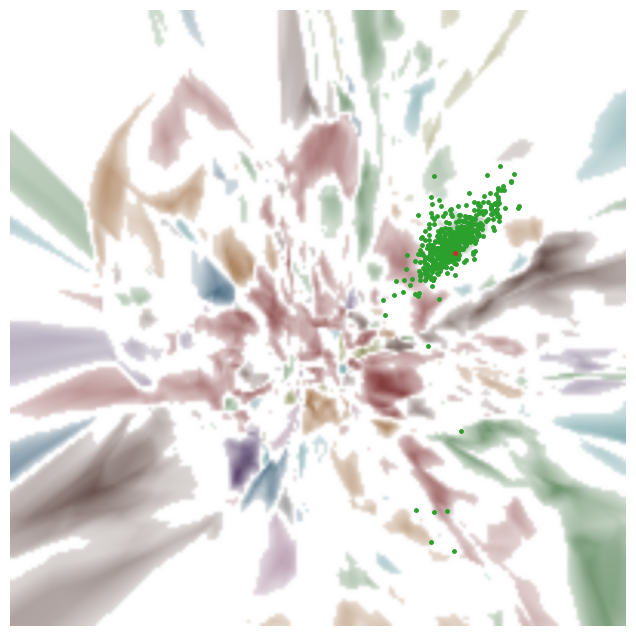

In [68]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider, train_data, projector, noisy_indicates, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Successfully load the TimeVis visualization model for iteration 200
Computing decision regions ...
Successfully load the TimeVis visualization model for iteration 200
Successfully load the TimeVis visualization model for iteration 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1019.54it/s]


Successfully load the TimeVis visualization model for iteration 200


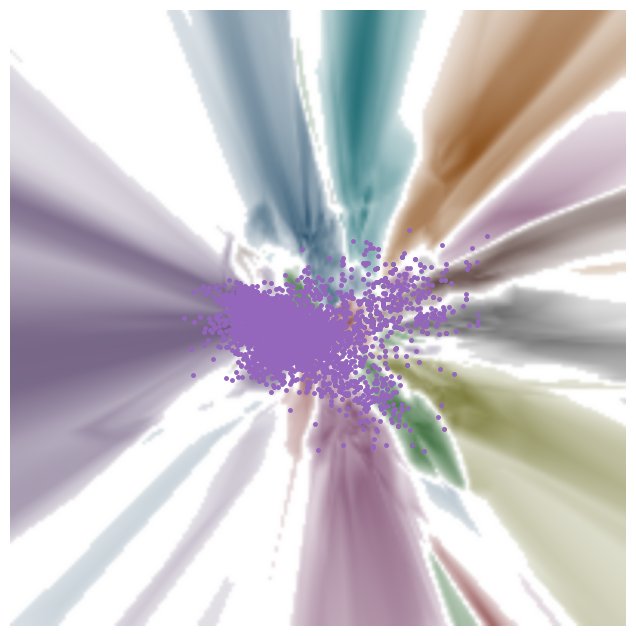

In [102]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data,R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [7]:
import json
import os
import numpy as np
clean_path = os.path.join(NOISY500, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(NOISY500, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
# noisy_indicates = []
# clean_indicates = []
selected_indicated = []
# pairs = []
for i in range(len(clean_labels)):
    if noisy_labels[i] == 1 or noisy_labels[i] == 8:
        selected_indicated.append(i)
        # pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})

print(len(selected_indicated))

10000


In [130]:

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
CLEAN_2d = projector.batch_project(200, np.dot(noisy_data,R))
NOISY_2d = projector.batch_project(200, np.dot(noisy2500_data,R2500))
low = []
high = []

for i in range(len(CLEAN_2d)):
    d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
    if d < 5:
        low.append(i)
    else:
        high.append(i)


print(len(low),len(high))

32115 17885


Computing decision regions ...


100%|██████████| 29/29 [00:00<00:00, 12636.07it/s]


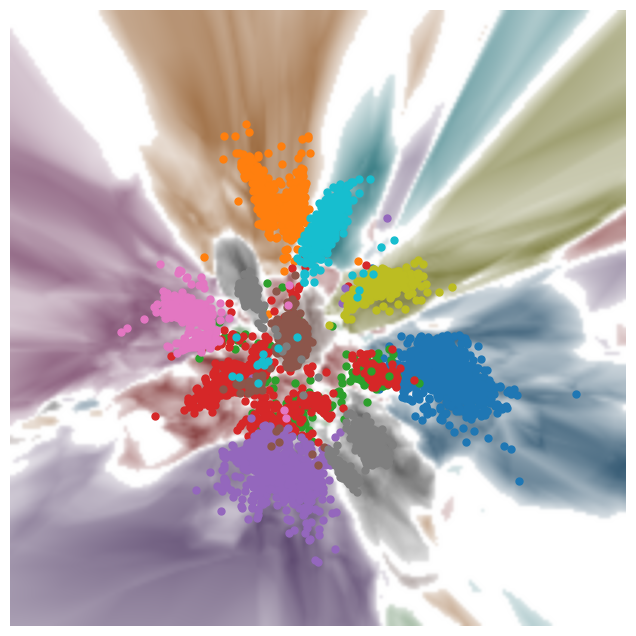

In [96]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY2500, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer_cc import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider, noisy_data, projector, low, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 13765.36it/s]


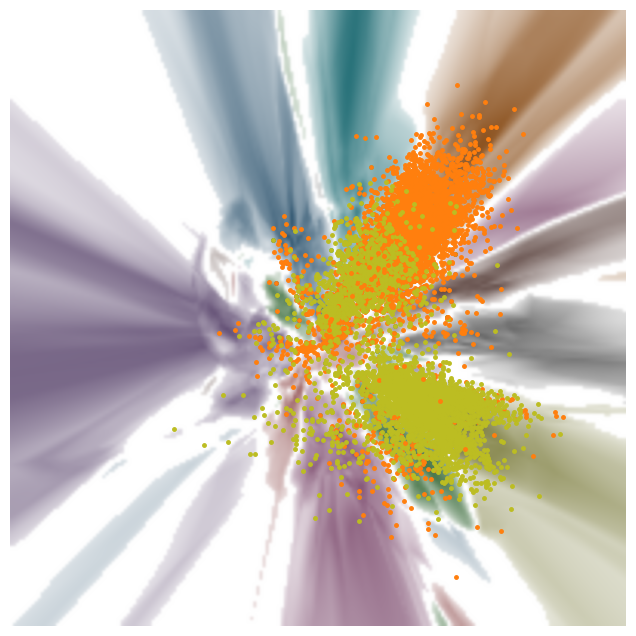

In [11]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data_provider.train_representation(200).squeeze(),R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 12237.57it/s]


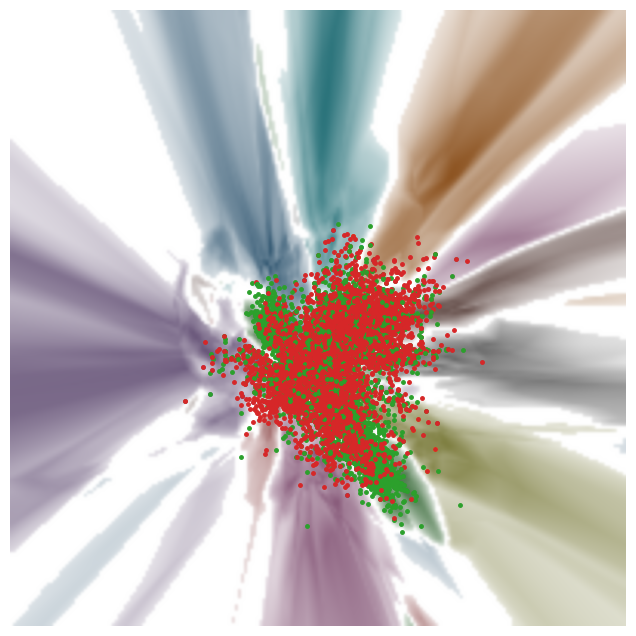

In [137]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy2500_data,R2500), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Successfully load the TimeVis visualization model for iteration 200
Computing decision regions ...
Successfully load the TimeVis visualization model for iteration 200
Successfully load the TimeVis visualization model for iteration 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1478.46it/s]


Successfully load the TimeVis visualization model for iteration 200


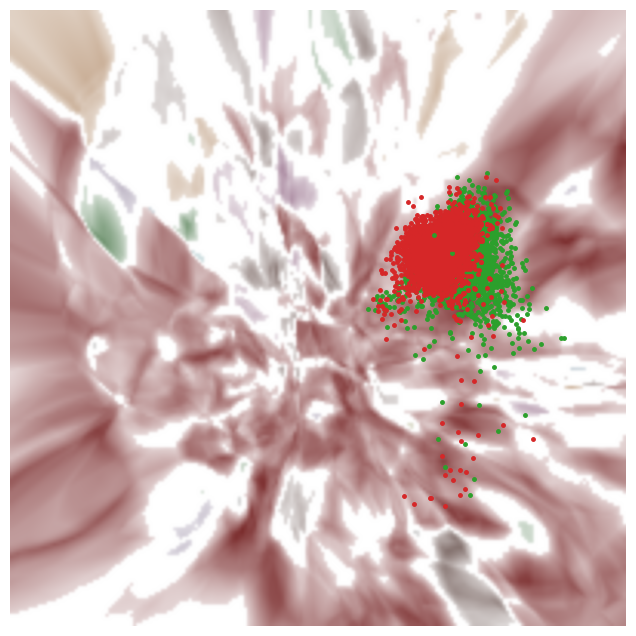

In [109]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider, noisy_data, projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))